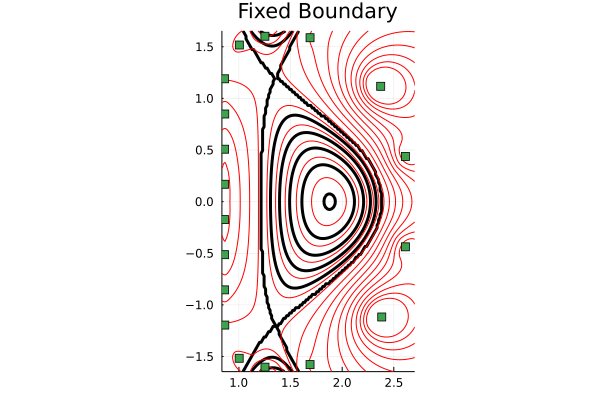

  0.208896 seconds (16.01 k allocations: 5.632 MiB)


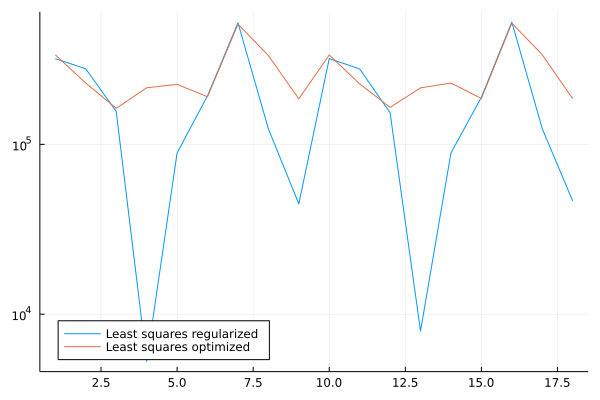

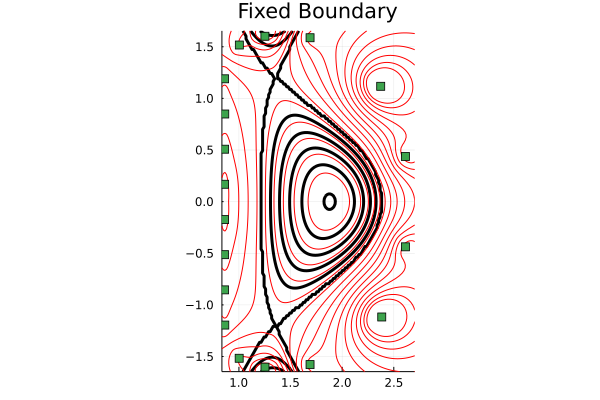

 * Status: success

 * Candidate solution
    Final objective value:     1.231642e+00

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 6.82e+04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.32e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.50e-02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.22e-02 ≰ 0.0e+00
    |g(x)|                 = 9.58e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    5
    ∇f(x) calls:   5
    ∇²f(x) calls:  2

  0.223061 seconds (16.76 k allocations: 15.571 MiB, 4.14% gc time)


In [121]:
using Revise
using AD_GS
import Equilibrium
using Plots

# Change between coils_D3D and coils_D3D_points to run with finite or singular coils
coils = coils_D3D#_points

δ = 0.7
ϵ = 0.32
κ = 1.9
B0 = 2.0
R0 = 1.8
qstar = 1.57
alpha = -0.155
S = Equilibrium.solovev(B0, R0, ϵ, δ, κ, alpha, qstar,B0_dir=1,Ip_dir=1,diverted=true,symmetric=true)

# δ = -0.7
# ϵ = 0.32
# κ = 1.9
# B0 = 2.0
# R0 = 1.7
# qstar = 1.57
# alpha = -0.155
# S = Equilibrium.solovev(B0, R0, ϵ, δ, κ, alpha, qstar,B0_dir=1,Ip_dir=1,diverted=true,symmetric=true)

@time currents = fixed_eq_currents(S,coils,λ_regularize=1E-13,λ_minimize=0.0, λ_zerosum=0.0, λ_d3d_innersum=0.0)
check_fixed_eq_currents(S,coils,currents,resolution=129)
display(plot!([c[1] for c in coils_D3D_points],[c[2] for c in coils_D3D_points],markershape=:rect,lw=0,label=""))
plot(abs.(currents),label="Least squares regularized", yaxis=:log)

@time currents = fixed_eq_currents(S,coils,λ_regularize=1E-13,λ_minimize=10E-0, λ_zerosum=1E-1, λ_d3d_innersum=0.0, verbose=true)
display(plot!(abs.(currents),label="Least squares optimized", yaxis=:log, legend=:bottomleft))
check_fixed_eq_currents(S,coils,currents,resolution=129)
display(plot!([c[1] for c in coils_D3D_points],[c[2] for c in coils_D3D_points],markershape=:rect,lw=0,label=""))